In [1]:
%matplotlib inline


from src.utils import create_plots, model_comparasion, is_pareto_efficient
from src.load_results import model_selection_parallel as model_selection

In [2]:
# results dir and methods
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import DTO
import numpy as np

In [3]:
def retrive_results(
    dataset,
    log_dir="results"
):
    log_dir = Path(log_dir)
    results = {}
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if file.startswith(dataset):
                pre_len = len(dataset)+len(str(log_dir))+2
                file_path = os.path.join(root, file)
                mehtod = str(os.path.join(root, file))[pre_len:-7]
                results[mehtod] = pd.read_pickle(file_path)
    return results


In [4]:
def final_results_df(
    results_dict,
    model_order = None,
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True,
    Fairness_threshold = 0.0,
    Performance_threshold = 0.0,
    ):

    df_list = []
    for key in (results_dict.keys() if model_order is None else model_order):
        _df = results_dict[key]

        # Calculate Mean and Variance for each run
        _df = _df.groupby(_df.index).agg(["mean", "std"]).reset_index()

        _df.columns = [' '.join(col).strip() for col in _df.columns.values]

        # Select Pareto Frontiers
        if pareto:
            _pareto_flag = is_pareto_efficient(
                -1*_df[["{}_{} mean".format(pareto_selection, Fairness_metric_name), "{}_{} mean".format(pareto_selection, Performance_metric_name)]].to_numpy()
                )
            _pareto_df = _df[_pareto_flag].copy()
        else:
            _pareto_df = _df.copy()

        # Filtering based on min fairness and performance
        _tmp_df = _pareto_df[_pareto_df["dev_{} mean".format(Performance_metric_name)]>=Performance_threshold].copy()
        _tmp_df = _tmp_df[_tmp_df["dev_{} mean".format(Fairness_metric_name)]>=Fairness_threshold].copy()

        if len(_tmp_df) >= 1:
            _pareto_df = _tmp_df
        
        # Rename and reorder the columns
        _pareto_df = _pareto_df[["{}_{} {}".format(phase, metric, value) for phase in ["test", "dev"] for metric in [Performance_metric_name, Fairness_metric_name] for value in ["mean", "std"]]].copy()
        _pareto_df["Models"] = [key]*len(_pareto_df)

        _final_DTO = DTO(
            fairness_metric=list(_pareto_df["dev_{} mean".format(Fairness_metric_name)]), 
            performacne_metric=list(_pareto_df["dev_{} mean".format(Performance_metric_name)]),
            utopia_fairness = 1, utopia_performance = 1
            )
        _pareto_df["dev_DTO mean"] = _final_DTO

        # Model selection
        if selection_criterion is not None:
            if selection_criterion == "DTO":
                selected_epoch_id = np.argmin(_pareto_df["dev_{} mean".format(selection_criterion)])
            else:
                selected_epoch_id = np.argmax(_pareto_df["dev_{} mean".format(selection_criterion)])
            _pareto_df = _pareto_df.iloc[[selected_epoch_id]].copy()
        
        df_list.append(_pareto_df)

    final_df = pd.concat(df_list)
    final_df.reset_index(inplace=True)

    if selection_criterion is not None:
        _over_DTO = DTO(
            fairness_metric=list(final_df["test_{} mean".format(Fairness_metric_name)]), 
            performacne_metric=list(final_df["test_{} mean".format(Performance_metric_name)]),
            utopia_fairness = 1, utopia_performance = 1
            )
        final_df["DTO"] = _over_DTO

        final_df = final_df[["Models"]+list(final_df.keys())[1:(9 if return_dev else 5)]+["DTO"]].copy()

    return final_df

In [5]:
def make_plot(plot_df):
    plot_df["EO Fairness"] = plot_df["test_{} mean".format("rms_TPR")]
    plot_df["Accuracy"] = plot_df["test_{} mean".format("accuracy")]

    figure = plt.figure(figsize=(6, 6), dpi = 150) 
    with sns.axes_style("white"):
        sns.lineplot(
            data=plot_df,
            x="Accuracy",
            y="EO Fairness",
            hue="Models",
            markers=True,
            style="Models",
        )

In [6]:
Moji_results = retrive_results("Moji")
Moji_results["FairBatch"] = Moji_results["OldFairBatch"]

In [7]:
Moji_main_results = final_results_df(
    results_dict = Moji_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True
    )
Moji_main_results

,Models,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,DTO
0,Vanilla,0.722981,0.004576,0.611870,0.014356,0.726650,0.003673,0.632302,0.013370,0.476849
1,Adv,0.756414,0.007271,0.893286,0.005623,0.747425,0.004549,0.912125,0.008507,0.265936
2,DAdv,0.755464,0.004076,0.904023,0.011218,0.748550,0.002405,0.915601,0.005007,0.262697
3,INLP,0.733433,NaN,0.855982,NaN,0.727625,NaN,0.859686,NaN,0.302983
4,FairBatch,0.750638,0.006012,0.905537,0.005046,0.744525,0.004995,0.917734,0.004761,0.266655
5,BTEO,0.753927,0.001433,0.877469,0.003756,0.746325,0.000998,0.896874,0.005401,0.274892
6,GatedBTEO,0.762106,0.002592,0.900764,0.014701,0.759775,0.003798,0.909445,0.006631,0.257762
7,GatedAdv,0.748962,0.005509,0.903242,0.018656,0.743275,0.003560,0.922978,0.012677,0.269039
8,GatedDAdv,0.755439,0.002157,0.892003,0.010166,0.748825,0.002473,0.911491,0.009448,0.267345


In [8]:
print(Moji_main_results.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
   Models &  test\_accuracy mean &  test\_accuracy std &  test\_rms\_TPR mean &  test\_rms\_TPR std &  dev\_accuracy mean &  dev\_accuracy std &  dev\_rms\_TPR mean &  dev\_rms\_TPR std &      DTO \\
\midrule
  Vanilla &            0.722981 &           0.004576 &           0.611870 &          0.014356 &           0.726650 &          0.003673 &          0.632302 &         0.013370 & 0.476849 \\
      Adv &            0.756414 &           0.007271 &           0.893286 &          0.005623 &           0.747425 &          0.004549 &          0.912125 &         0.008507 & 0.265936 \\
     DAdv &            0.755464 &           0.004076 &           0.904023 &          0.011218 &           0.748550 &          0.002405 &          0.915601 &         0.005007 & 0.262697 \\
     INLP &            0.733433 &                NaN &           0.855982 &               NaN &           0.727625 &               NaN &          0.859686 &              NaN & 0.302983 \\
Fa

In [9]:
Moji_plot_df = final_results_df(
    results_dict = Moji_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True
    )
Moji_plot_df

,index,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,Models,dev_DTO mean
0,0,0.722981,0.004576,0.611870,0.014356,0.726650,0.003673,0.632302,0.013370,Vanilla,0.458172
1,31,0.756414,0.007271,0.893286,0.005623,0.747425,0.004549,0.912125,0.008507,Adv,0.267425
2,32,0.752063,0.005902,0.907539,0.009727,0.745775,0.005636,0.916974,0.011534,Adv,0.267439
3,33,0.751538,0.009777,0.910219,0.016036,0.742250,0.009617,0.925246,0.016122,Adv,0.268372
4,35,0.744886,0.013777,0.917136,0.017954,0.736425,0.013615,0.918121,0.010558,Adv,0.276000
...,...,...,...,...,...,...,...,...,...,...,...
104,397,0.588047,0.120222,0.969623,0.040655,0.584675,0.114761,0.976239,0.029626,GatedDAdv,0.416004
105,404,0.579845,0.076264,0.972860,0.029172,0.576025,0.072689,0.978131,0.021842,GatedDAdv,0.424539
106,412,0.533658,0.073046,0.989707,0.018302,0.532675,0.071054,0.995009,0.007711,GatedDAdv,0.467352
107,413,0.585021,0.051133,0.971307,0.013316,0.581125,0.047121,0.981262,0.008475,GatedDAdv,0.419294


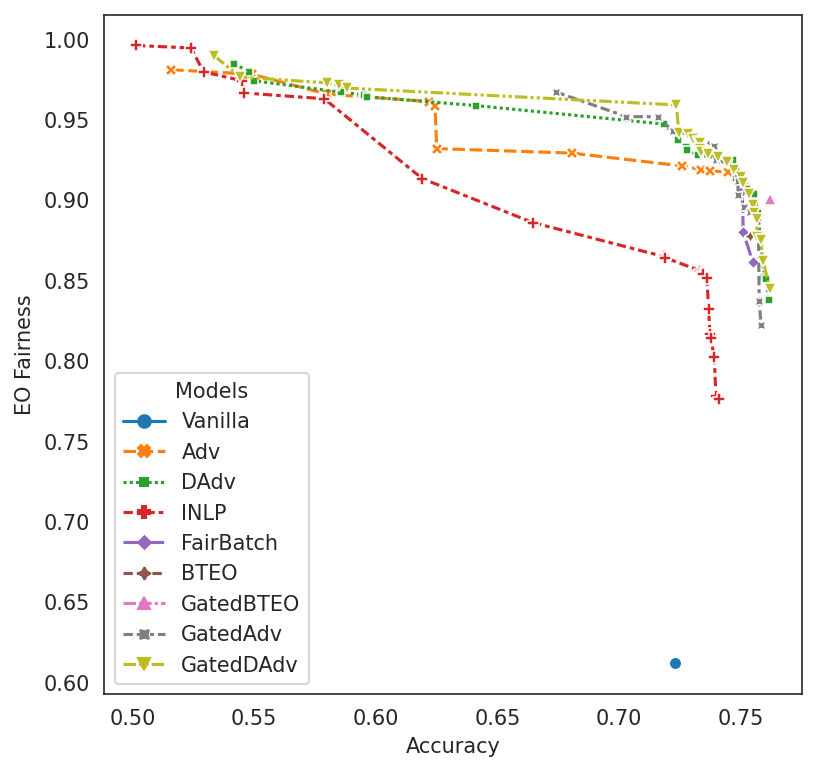

In [10]:
make_plot(Moji_plot_df)

In [11]:
Bios_both_results = retrive_results("Bios_both")

In [12]:
Bios_both_results["FairBatch"] = Bios_both_results["OldFairBatch"]
Bios_both_results["GatedAdv"] = pd.concat([Bios_both_results["GAdv"], Bios_both_results["BTGAdv"]])
Bios_both_results["GatedDAdv"] = pd.concat([Bios_both_results["GDAdv"], Bios_both_results["BTGDAdv"]])

In [13]:
Bios_both_main_results = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True
    )
Bios_both_main_results

,Models,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,DTO
0,Vanilla,0.815181,0.002435,0.555411,0.029533,0.807466,0.002962,0.540741,0.011691,0.481475
1,Adv,0.646016,0.045083,0.836838,0.011231,0.638627,0.043760,0.799317,0.030209,0.389777
2,DAdv,0.680895,0.054854,0.794713,0.067696,0.675794,0.054582,0.754632,0.066709,0.379435
3,INLP,0.813543,NaN,0.624426,NaN,0.803395,NaN,0.543710,NaN,0.419311
4,FairBatch,0.812416,0.001241,0.623468,0.018890,0.805002,0.001388,0.578378,0.014323,0.420671
5,GatedAdv,0.698492,0.035838,0.792417,0.059961,0.692470,0.036704,0.744349,0.035828,0.366057
6,GatedDAdv,0.699038,0.019692,0.797145,0.047948,0.693967,0.020421,0.741946,0.034637,0.362944


In [14]:
final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True,
    Fairness_threshold=0.5,
    Performance_threshold=0.7,
    )

,Models,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,DTO
0,Vanilla,0.815181,0.002435,0.555411,0.029533,0.807466,0.002962,0.540741,0.011691,0.481475
1,Adv,0.715314,0.056697,0.673155,0.053544,0.712541,0.058245,0.661834,0.042027,0.433444
2,DAdv,0.734351,0.037638,0.687555,0.049055,0.729646,0.036816,0.659528,0.036857,0.410111
3,INLP,0.813543,NaN,0.624426,NaN,0.803395,NaN,0.543710,NaN,0.419311
4,FairBatch,0.812416,0.001241,0.623468,0.018890,0.805002,0.001388,0.578378,0.014323,0.420671
5,GatedAdv,0.708736,0.050729,0.736469,0.079803,0.703678,0.050689,0.696036,0.041267,0.392789
6,GatedDAdv,0.707055,0.041894,0.771136,0.035268,0.701579,0.042559,0.727543,0.038521,0.371746


In [15]:
Bios_both_plot_df = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = False,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True
    )

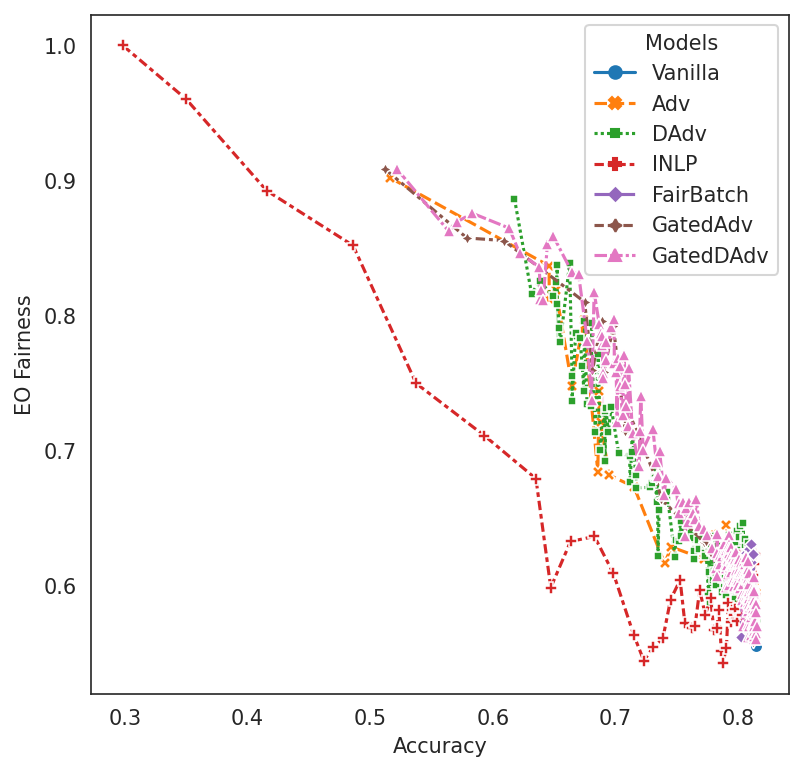

In [16]:
make_plot(Bios_both_plot_df)

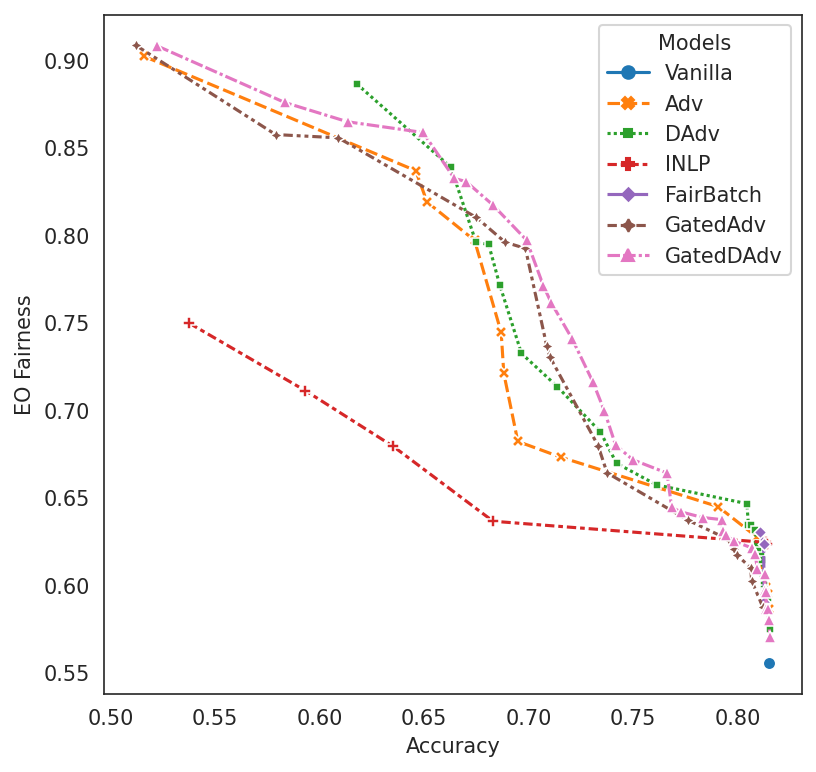

In [17]:
Bios_both_plot_df2 = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True,
    Fairness_threshold=0.5,
    Performance_threshold=0.5,
    )

make_plot(Bios_both_plot_df2)

In [18]:
Bios_gender_results = retrive_results("Bios_gender")

Bios_gender_results["FairBatch"] = Bios_gender_results["OldFairBatch"]
Bios_gender_results["GatedAdv"] = pd.concat([Bios_gender_results["GAdv"], Bios_gender_results["BTGAdv"]])
Bios_gender_results["GatedDAdv"] = pd.concat([Bios_gender_results["GDAdv"], Bios_gender_results["BTGDAdv"]])

In [19]:
Bios_gender_results.keys()

dict_keys(['Adv', 'BTFairBatch', 'BTGAdv', 'BTGDAdv', 'DAdv', 'FairBatch', 'GAdv', 'GDAdv', 'INLP', 'OldFairBatch', 'Vanilla', 'GatedAdv', 'GatedDAdv'])

In [21]:
Bios_gender_main_results = final_results_df(
    results_dict = Bios_gender_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True
    )
Bios_gender_main_results

,Models,test_accuracy mean,test_accuracy std,test_rms_TPR mean,test_rms_TPR std,dev_accuracy mean,dev_accuracy std,dev_rms_TPR mean,dev_rms_TPR std,DTO
0,Vanilla,0.822512,0.002410,0.851071,0.008095,0.819908,0.002125,0.863145,0.006457,0.231694
1,Adv,0.816637,0.002187,0.907356,0.007686,0.814308,0.001234,0.909428,0.008285,0.205438
2,DAdv,0.818480,0.001898,0.906376,0.004832,0.815252,0.001580,0.910746,0.006586,0.204242
3,INLP,0.823032,NaN,0.886249,NaN,0.820670,NaN,0.883876,NaN,0.210373
4,FairBatch,0.822382,0.001280,0.894995,0.012474,0.819868,0.001111,0.906735,0.001468,0.206335
5,GatedAdv,0.823037,0.002191,0.883569,0.008850,0.820226,0.002073,0.888371,0.007412,0.211830
6,GatedDAdv,0.819136,0.003358,0.889603,0.005943,0.816541,0.003499,0.898678,0.007902,0.211894


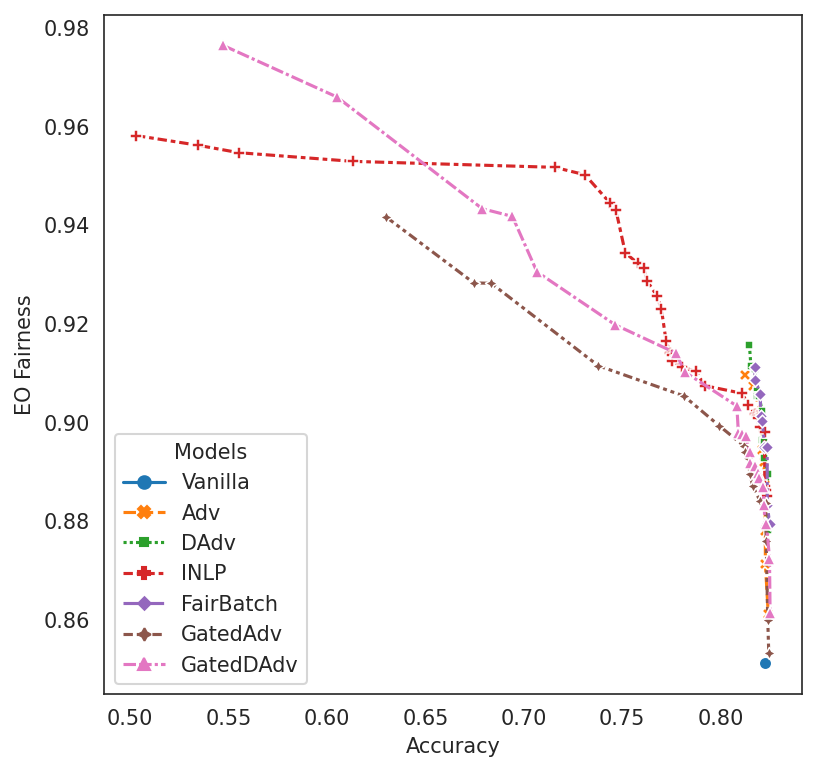

In [22]:
Bios_gender_plot_df = final_results_df(
    results_dict = Bios_gender_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    Fairness_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True,
    Fairness_threshold=0.5,
    Performance_threshold=0.5,
    )

make_plot(Bios_gender_plot_df)